In [9]:
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np

## Functions

In [10]:
path_felix = r"C:\Users\richt\Documents\ASME_data\train\Fusion360GalleryDataset_23hackathon_train"
base_path = path_felix

In [11]:
def extract_bodies(json_data):
    bodies_data = json_data.get('bodies', {})
    
    rows = []
    for body_id, body in bodies_data.items():
        physical_properties = body.get('physical_properties', {})
        
        # Extract volume and area from the physical_properties
        volume = physical_properties.get('volume', None)
        area = physical_properties.get('area', None)

        row = {
            'body_id': body_id,
            'name': body.get('name', None),
            'volume': volume,
            'area': area,
            'material_category': body.get('material_category', None),
            # Add any other attributes you want from the body object here.
        }
        rows.append(row)
    
    return rows


In [12]:
def extract_properties(json_data):
    properties = json_data.get('properties', {})

    # Extract features
    name = properties.get("name", None)
    vertex_count = properties.get("vertex_count", None)
    edge_count = properties.get("edge_count", None)
    face_count = properties.get("face_count", None)
    loop_count = properties.get("loop_count", None)
    shell_count = properties.get("shell_count", None)
    body_count = properties.get("body_count", None)
    area = properties.get("area", None)
    volume = properties.get("volume", None)
    design_type = properties.get("design_type", None)
    likes_count = properties.get("likes_count", None)
    comments_count = properties.get("comments_count", None)
    views_count = properties.get("views_count", None)
    categories = properties.get("categories", [])
    industries = properties.get("industries", [])

    return [name, vertex_count, edge_count, face_count, loop_count, shell_count, body_count, area, volume, design_type, likes_count, comments_count, views_count, categories, industries]

In [13]:
def extract_occurrences(json_data):
    occurrences_data = json_data.get('occurrences', {})
    
    rows = []
    for occurrence_id, occurrence in occurrences_data.items():
        bodies = occurrence.get('bodies', {})
        for body_id in bodies:
            row = {
                'occurrence_id': occurrence_id,
                'name': occurrence.get('name', None),
                'component': occurrence.get('component', None),
                'body_id': body_id
            }
            rows.append(row)
    
    return rows

In [14]:
def extract_components(json_data):
    components_data = json_data.get('components', {})
    
    rows = []
    for component_id, component in components_data.items():
        bodies = component.get('bodies', [])
        for body_id in bodies:
            row = {
                'component_id': component_id,
                'name': component.get('name', None),
                'body_id': body_id
            }
            rows.append(row)
    
    return rows

## Extract information from assembly.json

In [15]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_bodies(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_bodies = pd.DataFrame(all_data)

# Rearrange columns
df_bodies = df_bodies[['body_id', 'assembly_id', 'name', 'volume', 'area','material_category']]

In [16]:
df_bodies.shape

(131248, 6)

In [17]:
df_bodies.head()

,body_id,assembly_id,name,volume,area,material_category
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic


Extract properties information from assembly.json

In [18]:
all_categories = {}
all_industries = set()
data_properties = []  # Initialization here

# Single loop to gather information and extract data
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                _, _, _, _, _, _, _, _, _, _, _, _, _, categories, industries = extract_properties(json_data)
                
                for category in categories:
                    all_categories[category] = all_categories.get(category, 0) + 1
                    
                all_industries.update(industries)

# Keep top 'n' categories based on their frequency (say, n=10)
n = 10
top_categories = [cat[0] for cat in sorted(all_categories.items(), key=lambda x: x[1], reverse=True)[:n]]

# Creating dataframe columns
columns = ['assembly_id', 'name', 'vertex_count', 'edge_count', 'face_count', 'loop_count', 'shell_count', 'body_count', 'area', 'volume', 'design_type', 'likes_count', 'comments_count', 'views_count']
columns.extend([f'category_{cat}' for cat in top_categories])
columns.extend([f'industry_{industry}' for industry in all_industries])

# Populate dataframe
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                row_data = extract_properties(json_data)

                row = row_data[:13]

                categories = row_data[13]
                industries = row_data[14]

                for category in top_categories:
                    row.append(1 if category in categories else 0)

                for industry in all_industries:
                    row.append(1 if industry in industries else 0)

                data_properties.append([folder] + row)

df_properties = pd.DataFrame(data_properties, columns=columns)


In [19]:
df_properties.shape

(6336, 29)

In [20]:
df_properties.head()

,assembly_id,name,vertex_count,edge_count,face_count,loop_count,shell_count,body_count,area,volume,...,category_Furniture + Household,category_Tools,category_Automotive,category_Design,category_Toys,"industry_Architecture, Engineering & Construction",industry_Media & Entertainment,industry_Civil Infrastructure,industry_Product Design & Manufacturing,industry_Other Industries
0,100029_94515530,Untitled,350,507,211,253,6,6,7.652705,0.214475,...,0,0,0,0,0,0,0,0,1,0
1,100106_7f144e5b,Untitled,298,447,166,185,2,2,294.718856,42.378176,...,0,0,0,0,0,0,0,0,1,0
2,100112_bc0a563a,Untitled,1031,1500,678,837,64,64,23238.618896,6971.244191,...,0,0,1,0,0,1,0,0,1,0
3,100126_e58fbfba,Untitled,43,61,32,43,3,3,156.813970,121.481504,...,0,0,0,0,0,0,0,0,1,0
4,100138_119e1068,Untitled,50,78,29,30,1,1,14.929349,1.795948,...,0,0,0,0,1,0,0,0,1,0


Extract Occurences information from assembly.json

In [21]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_occurrences(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_occurrences = pd.DataFrame(all_data)

Extract components information from assembly.json

In [22]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_components(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_components = pd.DataFrame(all_data)

In [23]:
df_bodies.head()

,body_id,assembly_id,name,volume,area,material_category
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic


In [24]:
df_properties.head()

,assembly_id,name,vertex_count,edge_count,face_count,loop_count,shell_count,body_count,area,volume,...,category_Furniture + Household,category_Tools,category_Automotive,category_Design,category_Toys,"industry_Architecture, Engineering & Construction",industry_Media & Entertainment,industry_Civil Infrastructure,industry_Product Design & Manufacturing,industry_Other Industries
0,100029_94515530,Untitled,350,507,211,253,6,6,7.652705,0.214475,...,0,0,0,0,0,0,0,0,1,0
1,100106_7f144e5b,Untitled,298,447,166,185,2,2,294.718856,42.378176,...,0,0,0,0,0,0,0,0,1,0
2,100112_bc0a563a,Untitled,1031,1500,678,837,64,64,23238.618896,6971.244191,...,0,0,1,0,0,1,0,0,1,0
3,100126_e58fbfba,Untitled,43,61,32,43,3,3,156.813970,121.481504,...,0,0,0,0,0,0,0,0,1,0
4,100138_119e1068,Untitled,50,78,29,30,1,1,14.929349,1.795948,...,0,0,0,0,1,0,0,0,1,0


In [25]:
df_occurrences.head()

,occurrence_id,name,component,body_id,assembly_id
0,0b4c439a-0529-11ec-9ff8-020dc2b44123,Base:1,0b4a6edc-0529-11ec-99fe-020dc2b44123,0b41206c-0529-11ec-87d0-020dc2b44123,100221_4d7b66c4
1,0b4c91be-0529-11ec-9016-020dc2b44123,Lid:1,0b4a6edd-0529-11ec-999a-020dc2b44123,0b419630-0529-11ec-a6a6-020dc2b44123,100221_4d7b66c4
2,0b4d06e8-0529-11ec-9344-020dc2b44123,Hinge:1,0b4a4824-0529-11ec-9f70-020dc2b44123,0b40d208-0529-11ec-b1f1-020dc2b44123,100221_4d7b66c4
3,0b4dca30-0529-11ec-9bfd-020dc2b44123,Component5:1,0b4ae409-0529-11ec-b146-020dc2b44123,0b44546c-0529-11ec-b6a5-020dc2b44123,100221_4d7b66c4
4,0b4e666c-0529-11ec-bbbb-020dc2b44123,Component6:1,0b4a95ee-0529-11ec-bf21-020dc2b44123,0b420ad4-0529-11ec-aac9-020dc2b44123,100221_4d7b66c4


In [26]:
df_components.head()

,component_id,name,body_id,assembly_id
0,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530
1,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530
2,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530
3,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530
4,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530


In [27]:
# Prefix only if not already prefixed
if not df_properties.columns[0].startswith('properties_'):
    df_properties = df_properties.add_prefix('properties_')

# However, since 'assembly_id' is our merging key, we should exclude it from renaming
df_properties = df_properties.rename(columns={'properties_assembly_id': 'assembly_id'})

df_main = pd.merge(df_bodies, df_properties, on='assembly_id', how='inner')

In [28]:
df_main.shape

(131248, 34)

In [29]:
df_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,...,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0


# Prefix only if not already prefixed
if not df_occurrences.columns[0].startswith('occurrences_'):
    df_occurrences = df_occurrences.add_prefix('occurrences_')

# Rename the columns that are used for merging to their original names
df_occurrences = df_occurrences.rename(columns={'occurrences_body_id': 'body_id', 'occurrences_assembly_id': 'assembly_id'})

df_main = pd.merge(df_main, df_occurrences, on=['body_id', 'assembly_id'], how='inner')
df_main = df_main.drop(columns=["occurrences_occurrence_id", "occurrences_component"])

In [30]:
df_main.shape

(131248, 34)

In [31]:
df_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,...,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,0,1,0


In [32]:
# Prefix for df_components
if not df_components.columns[0].startswith('components_'):
    df_components = df_components.add_prefix('components_')

# Rename the columns used for merging to their original names
df_components = df_components.rename(columns={'components_body_id': 'body_id', 'components_assembly_id': 'assembly_id'})

# Merge with df_main
df_main = pd.merge(df_main, df_components[['body_id', 'assembly_id', 'components_name']], on=['body_id', 'assembly_id'], how='left')

In [33]:
df_main.shape

(131248, 35)

In [34]:
pd.set_option('display.max_columns', None)
df_main.tail(5)

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_design_type,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,components_name
131243,f95a09b6-0613-11ec-b131-0226f5980261,99852_1dadcef4,Body1,0.116680,1.729151,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,manubrio
131244,f95a5828-0613-11ec-ab9b-0226f5980261,99852_1dadcef4,Body1,0.002853,0.129364,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,tornillo doble
131245,f95a7efe-0613-11ec-bc18-0226f5980261,99852_1dadcef4,Body2,0.000024,0.016467,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,tornillo doble
131246,f95acd26-0613-11ec-a896-0226f5980261,99852_1dadcef4,Body1,0.002356,0.109956,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,tornillo sencillo
131247,f95af41c-0613-11ec-8208-0226f5980261,99852_1dadcef4,Body2,0.001571,0.094248,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,tornillo sencillo


## Visualization of main train

In [35]:
print(df_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131248 entries, 0 to 131247
Data columns (total 35 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   body_id                                                       131248 non-null  object 
 1   assembly_id                                                   131248 non-null  object 
 2   name                                                          131248 non-null  object 
 3   volume                                                        131248 non-null  float64
 4   area                                                          131248 non-null  float64
 5   material_category                                             131248 non-null  object 
 6   properties_name                                               131248 non-null  object 
 7   properties_vertex_count                                 

In [36]:
print(df_main.describe())

             volume          area  properties_vertex_count  \
count  1.312480e+05  1.312480e+05            131248.000000   
mean   4.784566e+13  4.099881e+08              2409.531063   
std    1.692769e+16  1.216469e+11              4834.969433   
min    0.000000e+00  0.000000e+00                 0.000000   
25%    1.963495e-02  1.198710e+00               397.000000   
50%    9.726926e-01  1.469507e+01              1058.000000   
75%    3.357134e+01  1.655849e+02              2649.000000   
max    6.131791e+18  4.341543e+13            109132.000000   

       properties_edge_count  properties_face_count  properties_loop_count  \
count          131248.000000          131248.000000          131248.000000   
mean             3633.397987            1535.654707            1838.380760   
std              7423.557083            2922.615736            3437.153063   
min                 0.000000               1.000000               0.000000   
25%               574.000000             273.000000

In [37]:
print(df_main.isnull().sum())

body_id                                                         0
assembly_id                                                     0
name                                                            0
volume                                                          0
area                                                            0
material_category                                               0
properties_name                                                 0
properties_vertex_count                                         0
properties_edge_count                                           0
properties_face_count                                           0
properties_loop_count                                           0
properties_shell_count                                          0
properties_body_count                                           0
properties_area                                                 0
properties_volume                                               0
properties

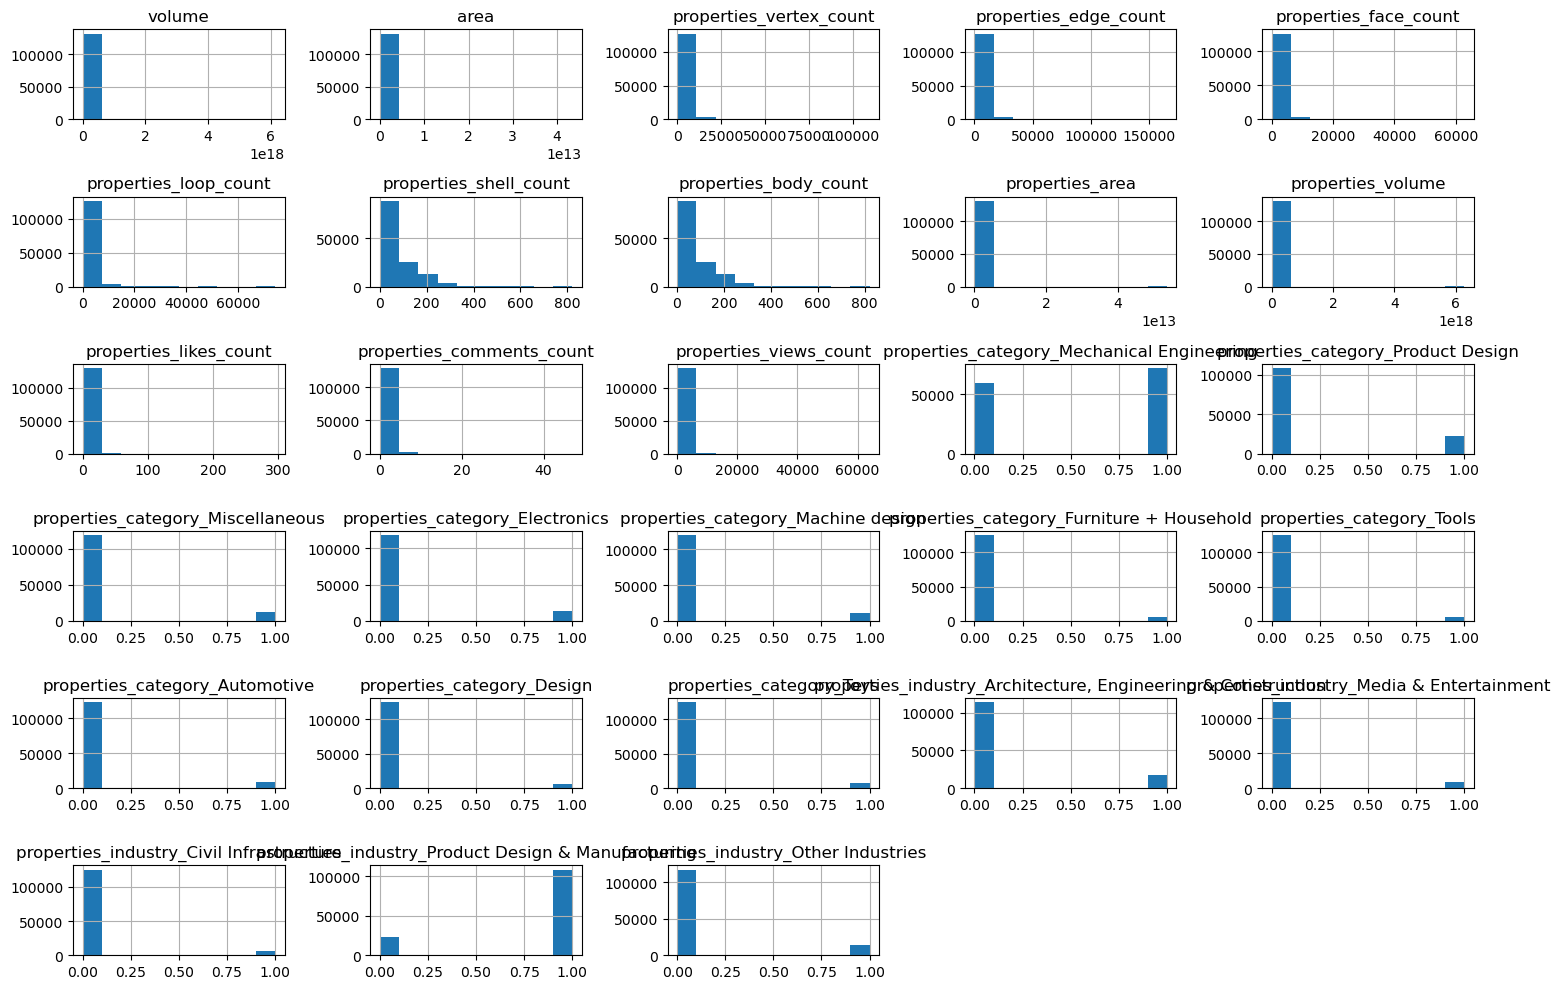

In [38]:
df_main.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

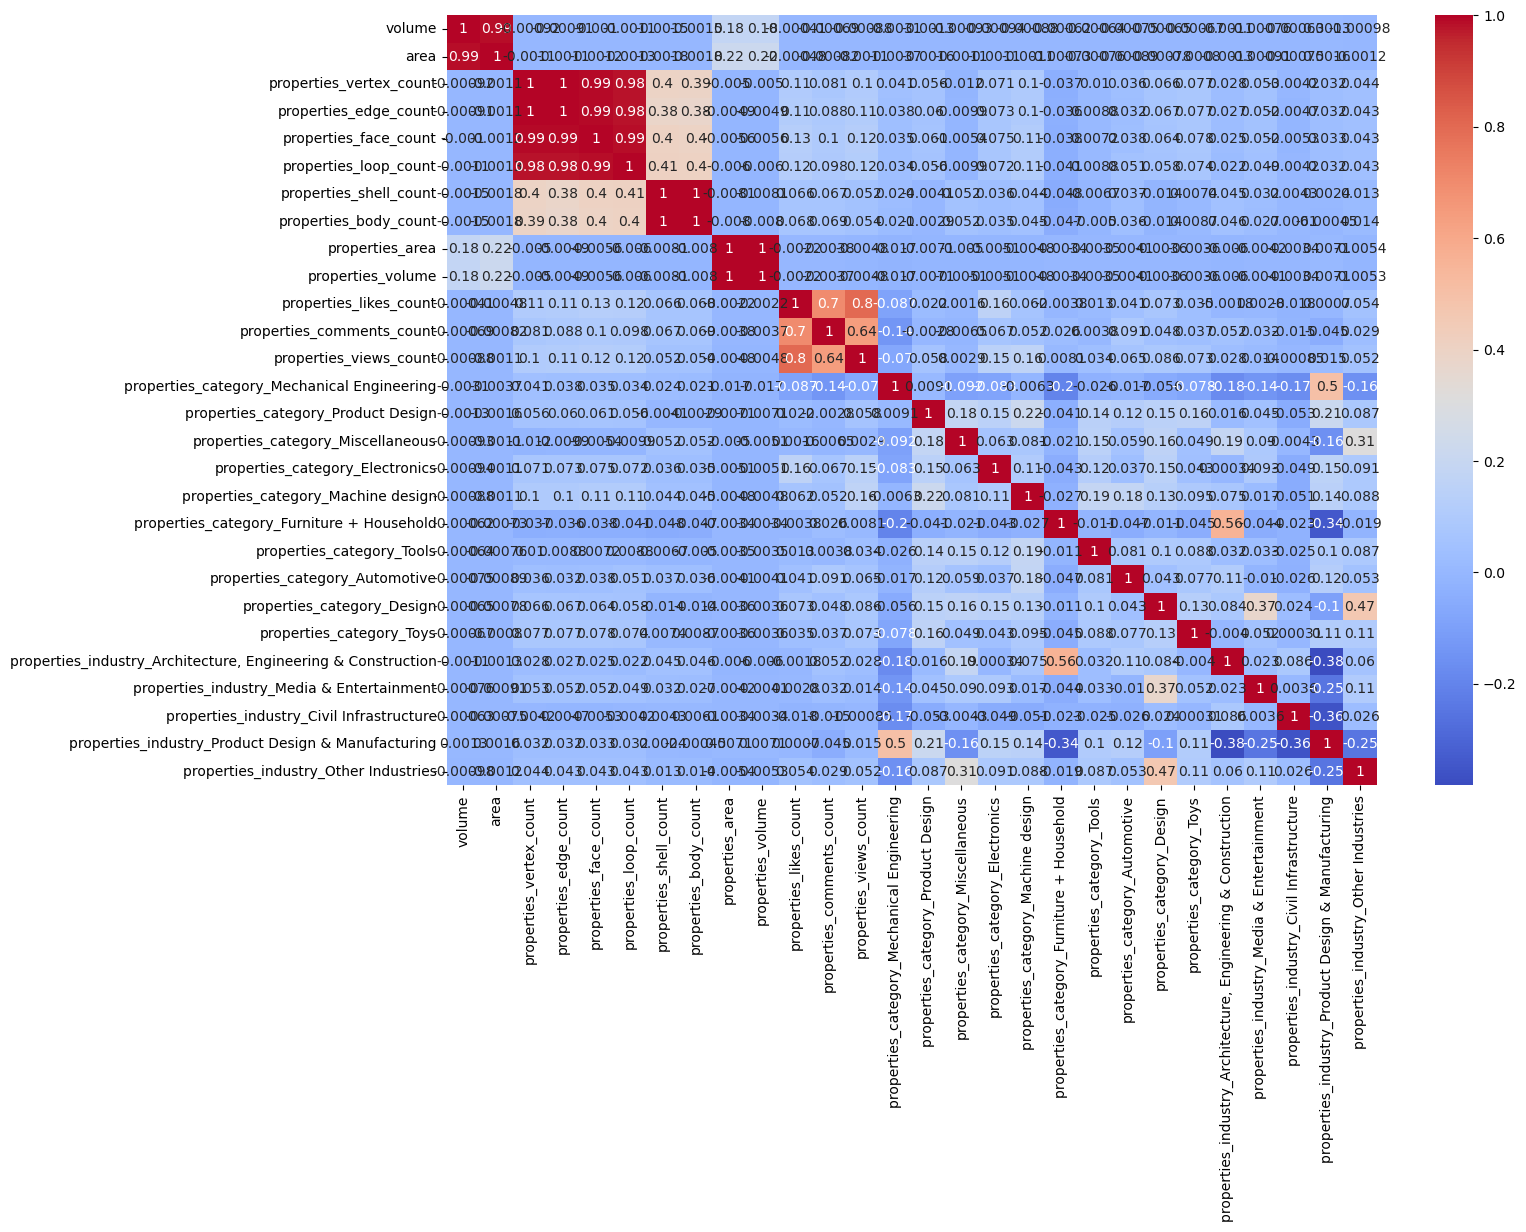

In [39]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df_main.corr(), annot=True, cmap='coolwarm')
plt.show()

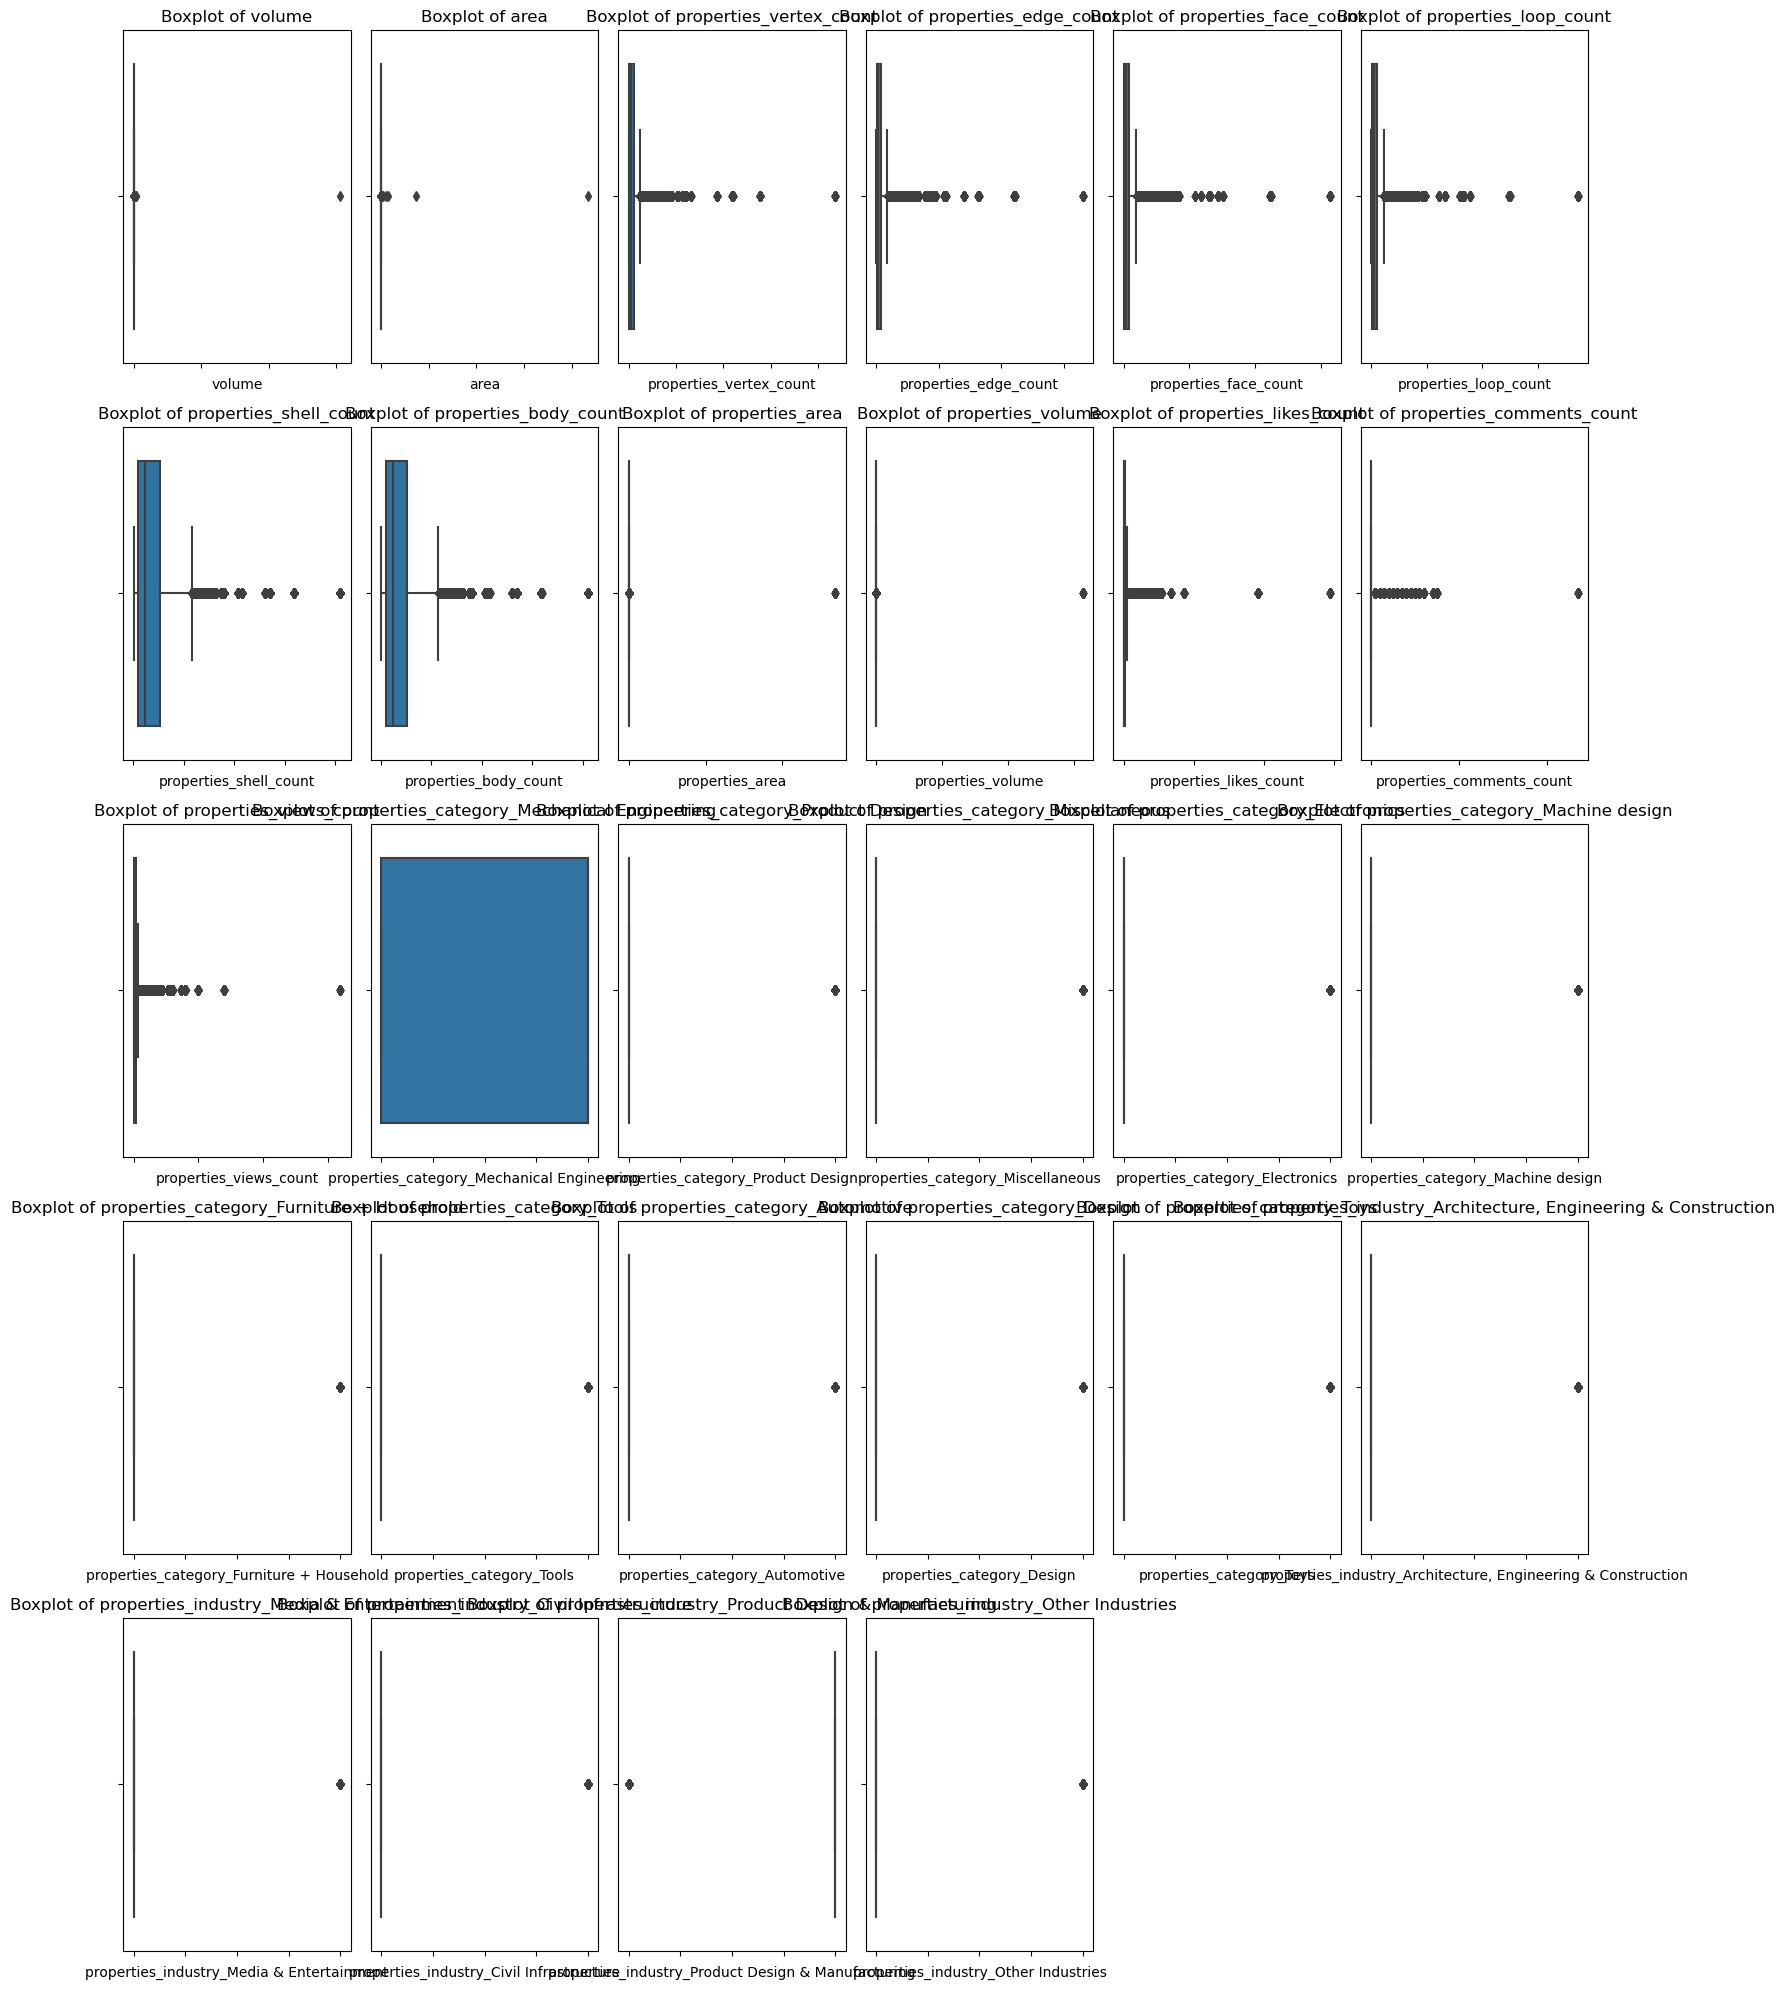

In [40]:
import warnings
warnings.filterwarnings('ignore')

# Get numerical columns
num_cols = df_main.select_dtypes(include=['float64', 'int64']).columns

# Create a grid of subplots
n = len(num_cols)
ncols = 6
nrows = n // ncols + (n % ncols != 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

for ax, col in zip(axes.ravel(), num_cols):
    sns.boxplot(data=df_main, x=col, ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# If number of columns is not a multiple of 3, delete any remaining empty subplots
if n % ncols != 0:
    for j in range(n % ncols, ncols):
        fig.delaxes(axes[nrows-1, j])

plt.tight_layout()
plt.show()

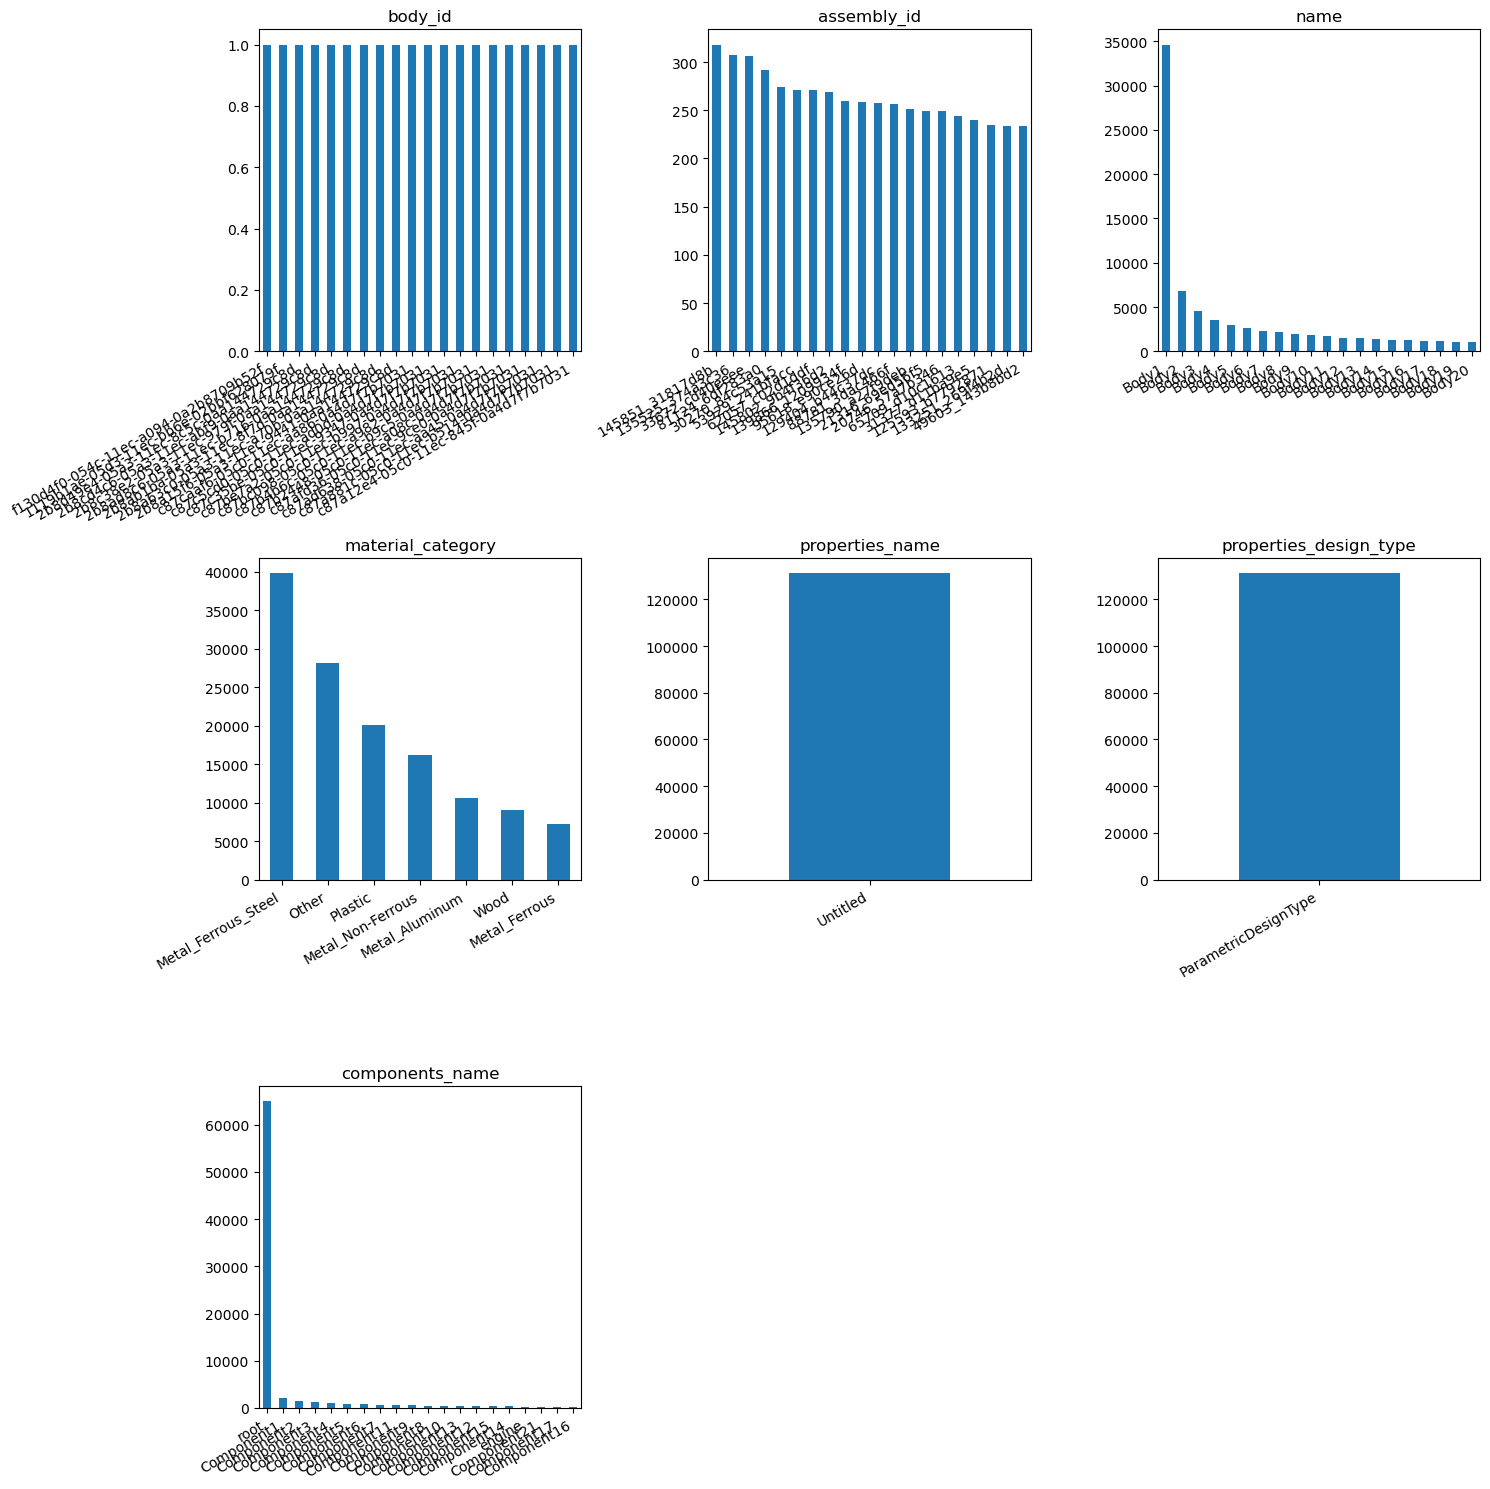

In [41]:
# Get categorical columns
cat_cols = df_main.select_dtypes(include=['object']).columns

# Define number of subplots along the vertical axis
N = 20
ncols = 3
nrows = len(cat_cols) // ncols + (len(cat_cols) % ncols != 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Loop over each column and plot in the subplot
for ax, col in zip(axes.ravel(), cat_cols):
    df_main[col].value_counts().head(N).plot(kind='bar', ax=ax, title=col)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# If the number of columns is not a multiple of 3, delete any remaining empty subplots
if len(cat_cols) % ncols != 0:
    for j in range(len(cat_cols) % ncols, ncols):
        fig.delaxes(axes[nrows-1, j])

plt.tight_layout()
plt.show()


In [42]:
columns_to_drop = ["properties_design_type", "properties_name", "occurrences_name"]

for col in columns_to_drop:
    if col in df_main.columns:
        df_main = df_main.drop(columns=col)

In [43]:
# Bodies name
df_main.loc[df_main['name'].str.match('^Body\d+$', na=False), 'name'] = np.nan

# Components name
df_main.loc[df_main['components_name'].str.match('^Component\d+$', na=False), 'components_name'] = np.nan


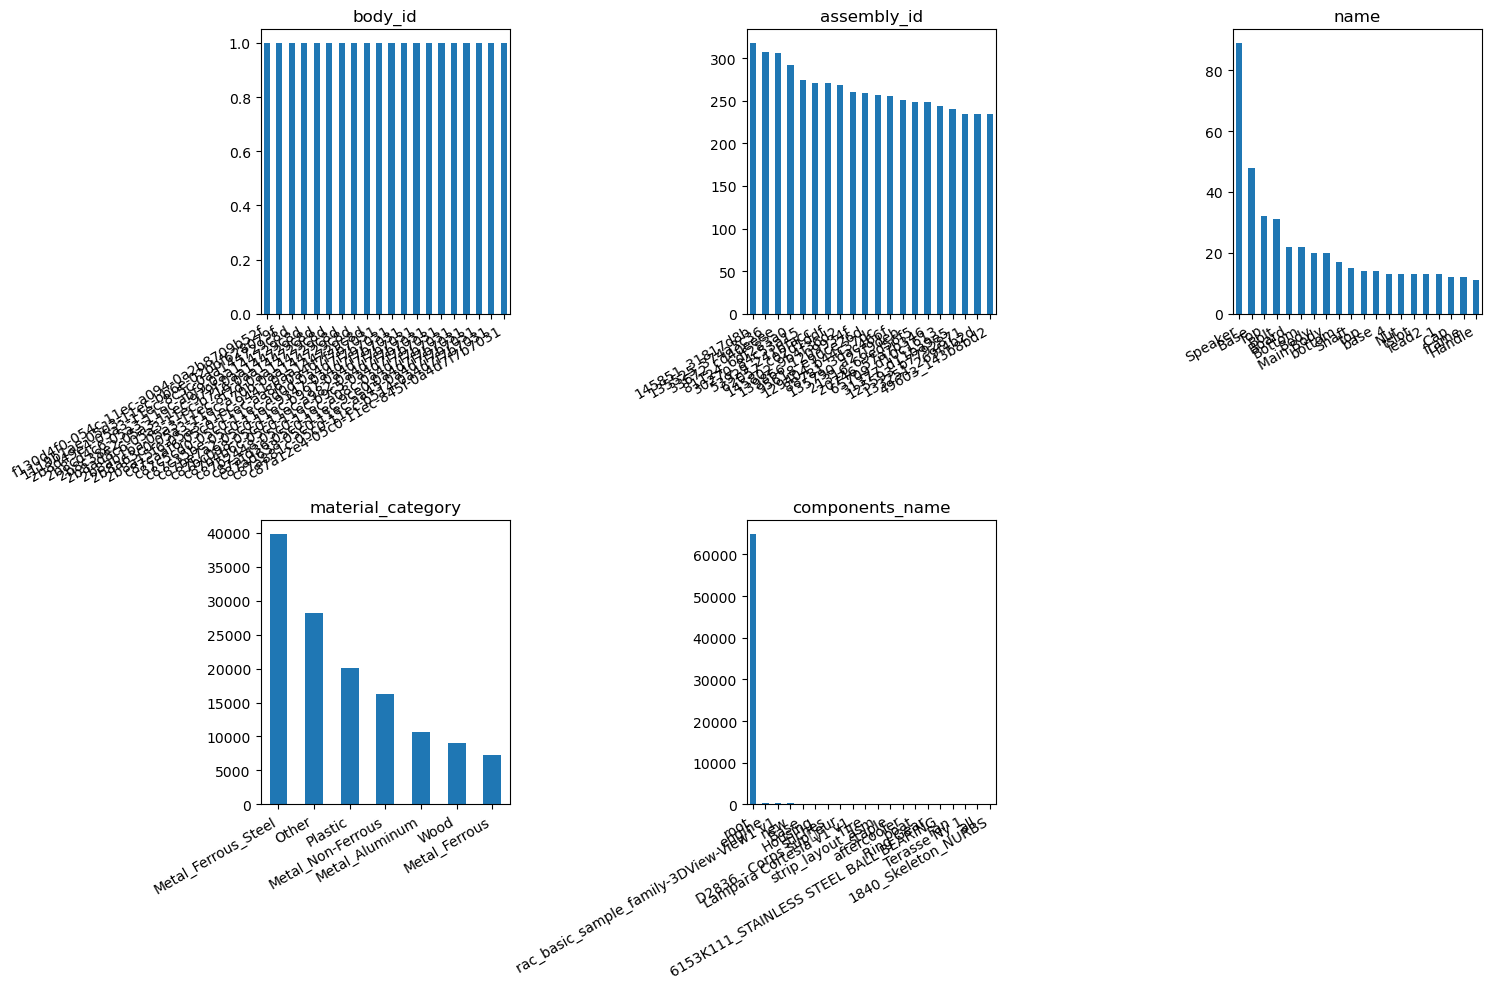

In [44]:
# Get categorical columns
cat_cols = df_main.select_dtypes(include=['object']).columns

# Define number of subplots along the vertical axis
N = 20
ncols = 3
nrows = len(cat_cols) // ncols + (len(cat_cols) % ncols != 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Loop over each column and plot in the subplot
for ax, col in zip(axes.ravel(), cat_cols):
    df_main[col].value_counts().head(N).plot(kind='bar', ax=ax, title=col)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# If the number of columns is not a multiple of 3, delete any remaining empty subplots
if len(cat_cols) % ncols != 0:
    for j in range(len(cat_cols) % ncols, ncols):
        fig.delaxes(axes[nrows-1, j])

plt.tight_layout()
plt.show()


In [45]:
print(df_main.shape[0])

131248


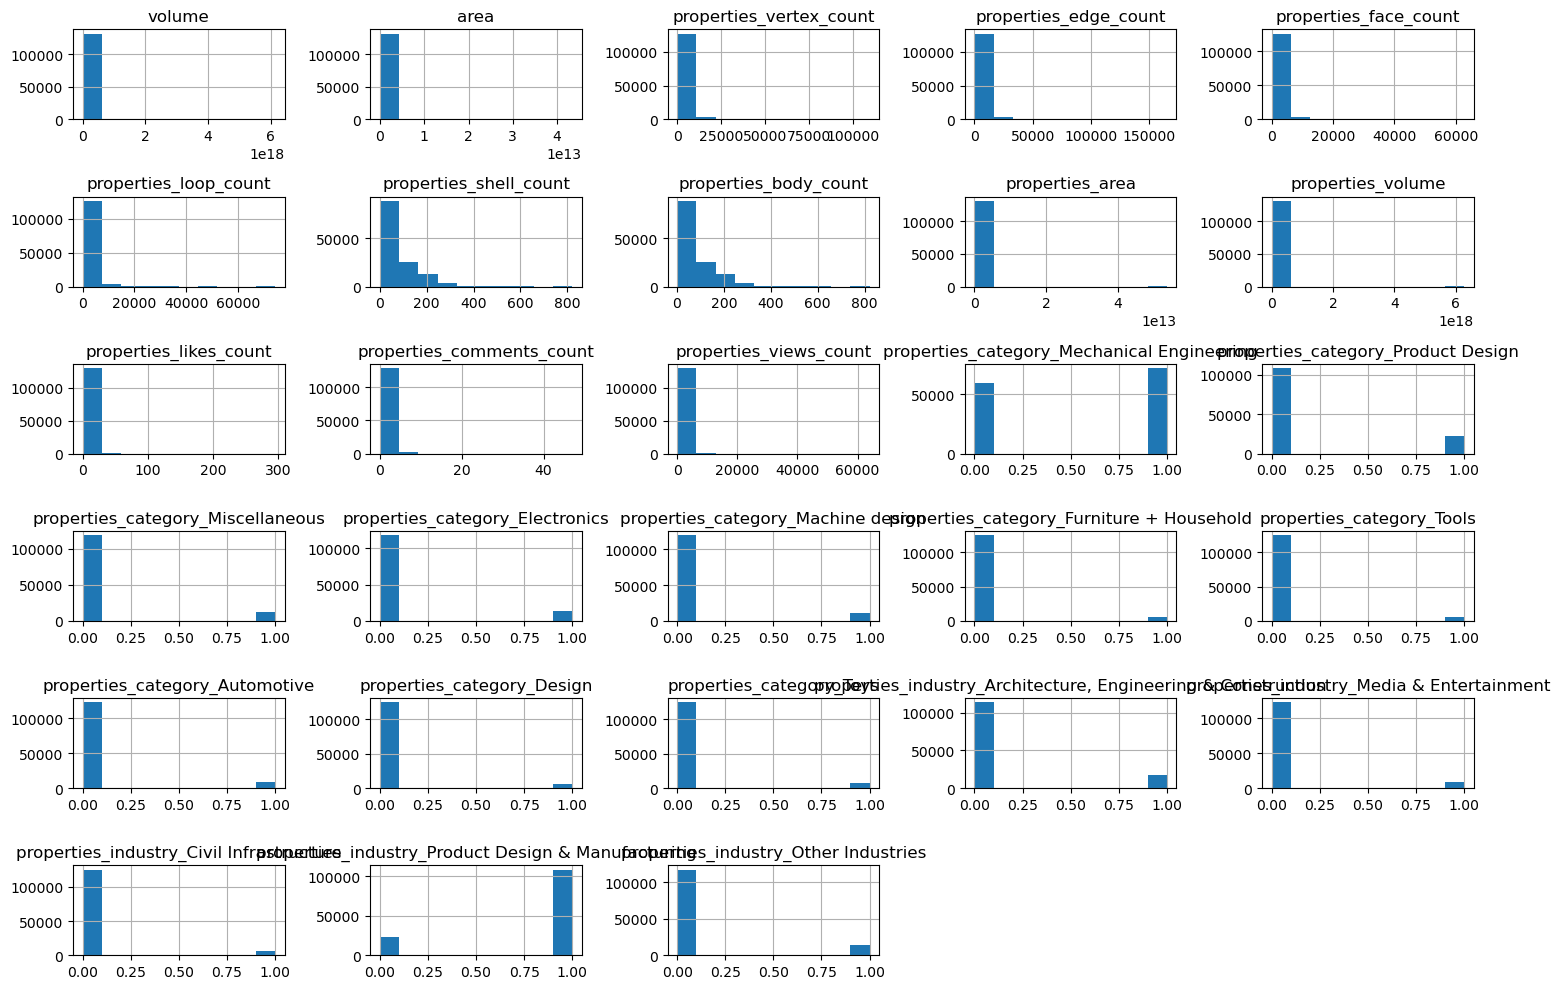

In [46]:
df_main.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In ANOVA, the F-value measures how much the means of each group differ from the overall group mean. Specifically:

- A large F-value suggests that at least two group means are different from each other. In other words, there is a significant difference in the means among the groups.

- A small F-value suggests that the group means are similar to each other and are similar to the overall group mean.

So, in the context of your dataset:

- A large F-value for a feature indicates that the means of that feature across different "material_category" groups are significantly different from each other. This implies that the feature might be strongly associated with the "material_category" (since different categories produce significantly different average values of the feature).

- A small F-value indicates that the feature's values don't vary much between different "material_category" groups, suggesting a weaker association.

That being said, it's important to consider both the F-value and the p-value when drawing conclusions. The p-value tells us if the observed F-value is statistically significant. Only if the p-value is below a certain threshold (e.g., 0.05) would we typically consider the difference in means to be statistically significant.

P-value

In summary, while p < 0.05 is a commonly used threshold, it's crucial to interpret p-values in the context of the specific study, the data, and the field of research.

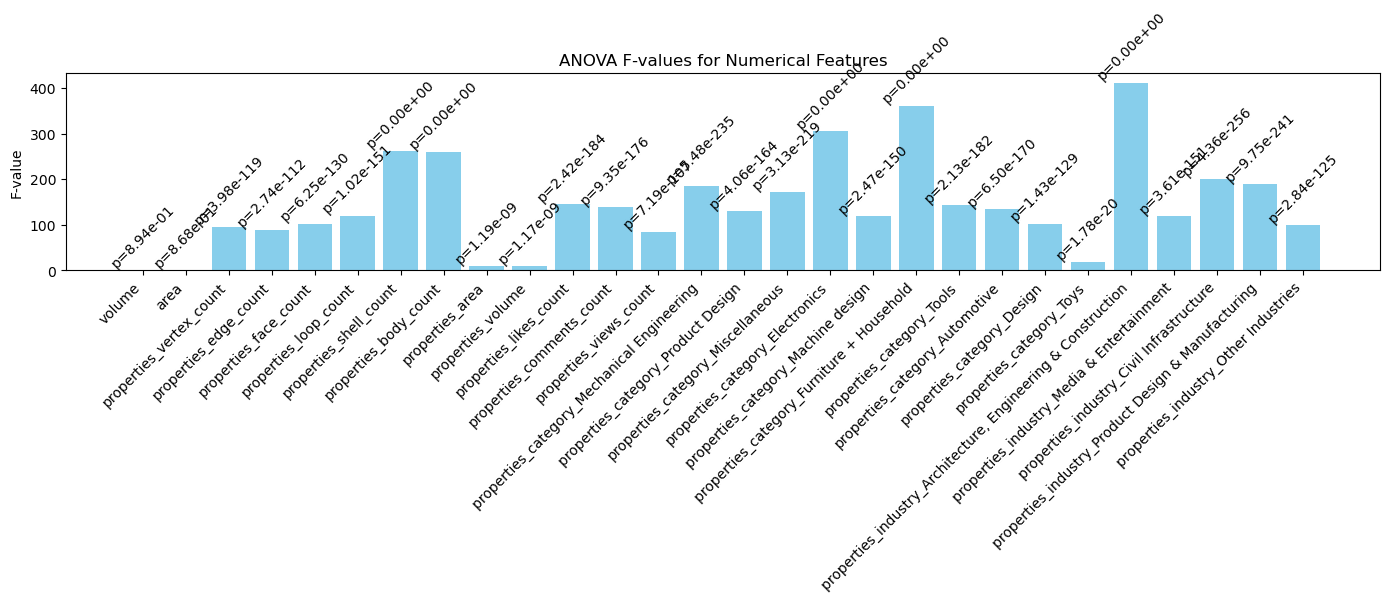

In [47]:
from scipy import stats

# List of numerical features
numeric_cols = df_main.select_dtypes(include=['float64', 'int64']).columns

f_values = []
p_values = []

# Compute ANOVA for each numerical feature
for col in numeric_cols:
    groups = [df_main[col][df_main['material_category'] == cat] for cat in df_main['material_category'].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    
    # Append the F-value and p-value for the current column to their respective lists
    f_values.append(f_val)
    p_values.append(p_val)

# Plot F-values
plt.figure(figsize=(14,6))
plt.bar(numeric_cols, f_values, color='skyblue')
plt.ylabel('F-value')
plt.title('ANOVA F-values for Numerical Features')
plt.xticks(rotation=45, ha="right")

# Annotate the bars with p-values
for i, (f_val, p_val) in enumerate(zip(f_values, p_values)):
    plt.text(i, f_val + 0.05, f"p={p_val:.2e}", ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()


## Export df_main train

In [48]:
df_main.to_pickle('df_main.pkl')

In [49]:
df_main.shape

(131248, 33)

## Import and Preprocess test data

In [50]:
test_base_path = r"C:\Users\richt\Documents\ASME_data\test\Fusion360GalleryDataset_23hackathon_test"

# Adjusted code for loading and preprocessing bodies data for test set
all_test_data_bodies = []

for folder in os.listdir(test_base_path):
    folder_path = os.path.join(test_base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_bodies(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_test_data_bodies.extend(data_for_folder)

df_test_bodies = pd.DataFrame(all_test_data_bodies)

# Adjusted code for loading and preprocessing properties data for test set
all_test_data_properties = []

for folder in os.listdir(test_base_path):
    folder_path = os.path.join(test_base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                row_data = extract_properties(json_data)
                row = row_data[:13]
                categories = row_data[13]
                industries = row_data[14]
                for category in top_categories:  # Assuming top_categories and all_industries are already defined
                    row.append(1 if category in categories else 0)
                for industry in all_industries:
                    row.append(1 if industry in industries else 0)
                all_test_data_properties.append([folder] + row)

df_test_properties = pd.DataFrame(all_test_data_properties, columns=columns)

# Adjusted code for loading and preprocessing occurrences data for test set
# all_test_data_occurrences = []

# for folder in os.listdir(test_base_path):
#    folder_path = os.path.join(test_base_path, folder)
#    if os.path.isdir(folder_path):
#        json_file = os.path.join(folder_path, 'assembly.json')
#        if os.path.exists(json_file):
#            with open(json_file, 'r') as f:
#                json_data = json.load(f)
#               data_for_folder = extract_occurrences(json_data)
#                for row in data_for_folder:
#                    row['assembly_id'] = folder
#                all_test_data_occurrences.extend(data_for_folder)

# df_test_occurrences = pd.DataFrame(all_test_data_occurrences)

# Adjusted code for loading and preprocessing components data for test set
all_test_data_components = []

for folder in os.listdir(test_base_path):
    folder_path = os.path.join(test_base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_components(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_test_data_components.extend(data_for_folder)

df_test_components = pd.DataFrame(all_test_data_components)

# Prefix for df_components
if not df_test_components.columns[0].startswith('components_'):
    df_test_components = df_test_components.add_prefix('components_')

# Rename the columns used for merging to their original names
df_test_components = df_test_components.rename(columns={'components_body_id': 'body_id', 'components_assembly_id': 'assembly_id'})

In [51]:
df_test_components.shape

(155, 4)

In [52]:
df_test_components.head()

,components_component_id,components_name,body_id,assembly_id
0,bbeff300-060c-11ec-a8e5-02ef91e90f5f,Component5,bbdf29da-060c-11ec-a52a-02ef91e90f5f,131068_085c0ed9
1,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,bbdf9f22-060c-11ec-ac81-02ef91e90f5f,131068_085c0ed9
2,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,bbe89f86-060c-11ec-8111-02ef91e90f5f,131068_085c0ed9
3,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,bbee1dec-060c-11ec-aabe-02ef91e90f5f,131068_085c0ed9
4,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,bbee44f6-060c-11ec-bd48-02ef91e90f5f,131068_085c0ed9


In [53]:
# Prefix columns for df_test_properties
if not df_test_properties.columns[0].startswith('properties_'):
    df_test_properties = df_test_properties.add_prefix('properties_')

# Rename 'properties_assembly_id' back to 'assembly_id'
df_test_properties = df_test_properties.rename(columns={'properties_assembly_id': 'assembly_id'})


In [54]:
df_test_properties.shape

(10, 29)

In [55]:
# Merge df_test_bodies and df_test_properties to create df_test_main
df_test_main = pd.merge(df_test_bodies, df_test_properties, on='assembly_id', how='inner')

In [56]:
df_test_main.shape

(155, 34)

In [57]:
# Merge df_test_main with df_test_components on 'assembly_id'
df_test_main = pd.merge(df_test_main, df_test_components, on='body_id', how='inner')

In [58]:
df_test_main.shape

(155, 37)

In [59]:
# Display the first few rows of df_test_main to verify
df_test_main.head()

,body_id,name,volume,area,material_category,assembly_id_x,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_design_type,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,components_component_id,components_name,assembly_id_y
0,bbdf29da-060c-11ec-a52a-02ef91e90f5f,Bolt M6-1,1.089020,7.679887,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,bbeff300-060c-11ec-a8e5-02ef91e90f5f,Component5,131068_085c0ed9
1,bbdf9f22-060c-11ec-ac81-02ef91e90f5f,Ramp,475.446755,972.513358,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,131068_085c0ed9
2,bbe89f86-060c-11ec-8111-02ef91e90f5f,Blade mount,241.470603,460.819725,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,131068_085c0ed9
3,bbee1dec-060c-11ec-aabe-02ef91e90f5f,Fixed blade,21.600000,73.200000,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,131068_085c0ed9
4,bbee44f6-060c-11ec-bd48-02ef91e90f5f,Bracket,11.563476,54.622106,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,bbf019d8-060c-11ec-8ebf-02ef91e90f5f,root,131068_085c0ed9


In [60]:
# Getting the percentual distribution of the target data
target_distribution = df_test_main["material_category"].value_counts(normalize=True) * 100
print(target_distribution)

Series([], Name: material_category, dtype: float64)


In [61]:
# Drop the 'components_component_id' column
df_test_main = df_test_main.drop(columns=['components_component_id'])

In [62]:
# Resolve the duplicate 'body_id' columns
df_test_main = df_test_main.drop(columns=['assembly_id_y'])
df_test_main = df_test_main.rename(columns={'assembly_id_x': 'assembly_id'})

In [63]:
df_test_main.head()

,body_id,name,volume,area,material_category,assembly_id,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_design_type,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,"properties_industry_Architecture, Engineering & Construction",properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,components_name
0,bbdf29da-060c-11ec-a52a-02ef91e90f5f,Bolt M6-1,1.089020,7.679887,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,Component5
1,bbdf9f22-060c-11ec-ac81-02ef91e90f5f,Ramp,475.446755,972.513358,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,root
2,bbe89f86-060c-11ec-8111-02ef91e90f5f,Blade mount,241.470603,460.819725,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,root
3,bbee1dec-060c-11ec-aabe-02ef91e90f5f,Fixed blade,21.600000,73.200000,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,root
4,bbee44f6-060c-11ec-bd48-02ef91e90f5f,Bracket,11.563476,54.622106,None,131068_085c0ed9,Untitled,804,1311,546,580,7,7,2191.649089,1225.585809,ParametricDesignType,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,root


In [64]:
df_test_main.shape

(155, 35)

In [65]:
columns_to_drop = ["properties_design_type", "properties_name", "occurrences_name"]

for col in columns_to_drop:
    if col in df_test_main.columns:
        df_test_main = df_test_main.drop(columns=col)

In [66]:
df_test_main.shape

(155, 33)

In [67]:
df_main.columns.tolist()

['body_id',
 'assembly_id',
 'name',
 'volume',
 'area',
 'material_category',
 'properties_vertex_count',
 'properties_edge_count',
 'properties_face_count',
 'properties_loop_count',
 'properties_shell_count',
 'properties_body_count',
 'properties_area',
 'properties_volume',
 'properties_likes_count',
 'properties_comments_count',
 'properties_views_count',
 'properties_category_Mechanical Engineering',
 'properties_category_Product Design',
 'properties_category_Miscellaneous',
 'properties_category_Electronics',
 'properties_category_Machine design',
 'properties_category_Furniture + Household',
 'properties_category_Tools',
 'properties_category_Automotive',
 'properties_category_Design',
 'properties_category_Toys',
 'properties_industry_Architecture, Engineering & Construction',
 'properties_industry_Media & Entertainment',
 'properties_industry_Civil Infrastructure',
 'properties_industry_Product Design & Manufacturing',
 'properties_industry_Other Industries',
 'components_n

In [68]:
df_test_main.columns.tolist()

['body_id',
 'name',
 'volume',
 'area',
 'material_category',
 'assembly_id',
 'properties_vertex_count',
 'properties_edge_count',
 'properties_face_count',
 'properties_loop_count',
 'properties_shell_count',
 'properties_body_count',
 'properties_area',
 'properties_volume',
 'properties_likes_count',
 'properties_comments_count',
 'properties_views_count',
 'properties_category_Mechanical Engineering',
 'properties_category_Product Design',
 'properties_category_Miscellaneous',
 'properties_category_Electronics',
 'properties_category_Machine design',
 'properties_category_Furniture + Household',
 'properties_category_Tools',
 'properties_category_Automotive',
 'properties_category_Design',
 'properties_category_Toys',
 'properties_industry_Architecture, Engineering & Construction',
 'properties_industry_Media & Entertainment',
 'properties_industry_Civil Infrastructure',
 'properties_industry_Product Design & Manufacturing',
 'properties_industry_Other Industries',
 'components_n

In [69]:
# Get the list of column names
cols = list(df_test_main.columns)

# Remove 'assembly_id' from its current position
cols.remove('assembly_id')

# Insert it at the desired position (1 for second place as indexing starts at 0)
cols.insert(1, 'assembly_id')

# Re-index the DataFrame using the reordered list of column names
df_test_main = df_test_main[cols]


In [70]:
df_test_main.columns.tolist()

['body_id',
 'assembly_id',
 'name',
 'volume',
 'area',
 'material_category',
 'properties_vertex_count',
 'properties_edge_count',
 'properties_face_count',
 'properties_loop_count',
 'properties_shell_count',
 'properties_body_count',
 'properties_area',
 'properties_volume',
 'properties_likes_count',
 'properties_comments_count',
 'properties_views_count',
 'properties_category_Mechanical Engineering',
 'properties_category_Product Design',
 'properties_category_Miscellaneous',
 'properties_category_Electronics',
 'properties_category_Machine design',
 'properties_category_Furniture + Household',
 'properties_category_Tools',
 'properties_category_Automotive',
 'properties_category_Design',
 'properties_category_Toys',
 'properties_industry_Architecture, Engineering & Construction',
 'properties_industry_Media & Entertainment',
 'properties_industry_Civil Infrastructure',
 'properties_industry_Product Design & Manufacturing',
 'properties_industry_Other Industries',
 'components_n

## Look at test old

In [72]:
test_base_path_old = r"C:\Users\richt\Documents\ASME_data\test_old"

# Adjusted code for loading and preprocessing bodies data for test set
all_test_data_bodies = []

for folder in os.listdir(test_base_path_old):
    folder_path = os.path.join(test_base_path_old, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_bodies(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_test_data_bodies.extend(data_for_folder)

df_test_bodies = pd.DataFrame(all_test_data_bodies)

# Adjusted code for loading and preprocessing properties data for test set
all_test_data_properties = []

for folder in os.listdir(test_base_path_old):
    folder_path = os.path.join(test_base_path_old, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                row_data = extract_properties(json_data)
                row = row_data[:13]
                categories = row_data[13]
                industries = row_data[14]
                for category in top_categories:  # Assuming top_categories and all_industries are already defined
                    row.append(1 if category in categories else 0)
                for industry in all_industries:
                    row.append(1 if industry in industries else 0)
                all_test_data_properties.append([folder] + row)

df_test_properties = pd.DataFrame(all_test_data_properties, columns=columns)

# Adjusted code for loading and preprocessing occurrences data for test set
# all_test_data_occurrences = []

# for folder in os.listdir(test_base_path):
#    folder_path = os.path.join(test_base_path, folder)
#    if os.path.isdir(folder_path):
#        json_file = os.path.join(folder_path, 'assembly.json')
#        if os.path.exists(json_file):
#            with open(json_file, 'r') as f:
#                json_data = json.load(f)
#               data_for_folder = extract_occurrences(json_data)
#                for row in data_for_folder:
#                    row['assembly_id'] = folder
#                all_test_data_occurrences.extend(data_for_folder)

# df_test_occurrences = pd.DataFrame(all_test_data_occurrences)

# Adjusted code for loading and preprocessing components data for test set
all_test_data_components = []

for folder in os.listdir(test_base_path_old):
    folder_path = os.path.join(test_base_path_old, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_components(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_test_data_components.extend(data_for_folder)

df_test_components = pd.DataFrame(all_test_data_components)

# Prefix for df_components
if not df_test_components.columns[0].startswith('components_'):
    df_test_components = df_test_components.add_prefix('components_')

# Rename the columns used for merging to their original names
df_test_components = df_test_components.rename(columns={'components_body_id': 'body_id', 'components_assembly_id': 'assembly_id'})

In [73]:
df_test_components.shape

(155, 4)

In [74]:
# Getting the percentual distribution of the target data
target_distribution = df_test_bodies["material_category"].value_counts(normalize=True) * 100
print(target_distribution)

Metal_Ferrous_Steel    29.677419
Metal_Non-Ferrous      28.387097
Other                  12.258065
Metal_Aluminum         10.322581
Wood                    9.677419
Metal_Ferrous           5.161290
Plastic                 4.516129
Name: material_category, dtype: float64


In [76]:
df_test_old_labels = df_test_bodies["material_category"]
df_test_old_labels.to_pickle('df_y_test_old.pkl')

## Export df_test_main

In [71]:
df_test_main.to_pickle('df_test_main.pkl')